# Cointegration and Stationarity for Pairs Trading

In this Jupyter notebook, I would like to show you some ideas behind Pair Trading and Statistical Arbitrage, higlighting the importance of statistical analysis, in the form of Cointegration Analysis as well as defining, and analysing the stationarity of a time series.

These are ideas that can be applicable in a pair trading context, however we let the reader analyse on their own and further develop on this initial grounding, which is purely based on Time Series Analyisis and Statistics, and no trading results are presented for the sake of the notebook! 


In [55]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#Import cufflinks as cf
import cufflinks as cf
cf.set_config_file(offline=True, dimensions=((1000,600)))

# Import plotly express for EF plot
import plotly.express as px
px.defaults.width, px.defaults.height = 1000,600
# Set precision
pd.set_option('display.precision', 4)

# Import Cointegrated Test from StatsModels
from statsmodels.tsa.vector_ar.vecm import coint_johansen
# Vector Autoregression
from statsmodels.tsa.api import VAR

import statsmodels.api as sm #or as ts. 

from scipy import optimize

In [56]:
class Pair_Trading:
    def __init__(self, ticker_A, ticker_B, market, start, end):
        self.ticker_A=ticker_A
        self.ticker_B=ticker_B
        self.market = market
        self.start = start
        self.end = end
        
    def load_data(self):
        """This function loads multiple Stock Prices data at once from Yahoo Finance"""
        tickers = [self.ticker_A, self.ticker_B, self.market]
        # Fetch data for all tickers in one DataFrame
        data = yf.download(tickers, start=self.start, end=self.end, progress=False, group_by='ticker')
        return data

    
    def get_close_prices(self):
        """This function extracts the Close prices for all tickers"""
        data = self.load_data()
        # Check if the DataFrame has a MultiIndex in columns (group_by='ticker')
        close_prices = data.loc[:, (slice(None), 'Close')]
        # Flatten MultiIndex columns
        close_prices.columns = [f"{ticker} Close" for ticker in close_prices.columns.get_level_values(0)]
            
        return close_prices
    
    
    def normalized_prices(self):
        """This function outputs a dataframe of Normalized Prices"""
        prices = self.get_close_prices()
        normalized_prices = prices/prices.iloc[0]
        
        return normalized_prices
    
    def normalized_plot(self):
        """This function plots the Normalised Price Time Series"""
        normalized_prices = self.normalized_prices()
        normalized_prices.plot(figsize=(16,6), color=('b', 'r', 'g'))
        plt.title(f'Normalised Prices across {self.ticker_A}, {self.ticker_B} and {self.market}')
        
    def returns(self):
        """This function outputs the log-returns"""
        prices = self.get_close_prices()
        returns = np.log(prices).diff().dropna()
        
        return returns
        
    def returns_plot(self):
        """This function plots the log-returns"""
        returns = self.returns()
        returns.plot(figsize=(16,9), color=('b', 'r', 'g'), subplots=True, linewidth=0.5, title='Return Time Series across the Cointegrated Pairs and the Market')
    
    def returns_dist(self):
        """This function plots the distribution of prices"""
        returns = np.log(self.get_close_prices()).diff().dropna()
        plt.hist(returns, color=('b', 'r', 'g'))
        plt.title(f'Log-Returns Distribution across {self.ticker_A}, {self.ticker_B} and {self.market}')
        
        
    def scatter_plot(self, price_A, price_B):
        """This function creates a scatter plot for the two possible Cointegrated Prices"""
        plt.scatter(price_A, price_B)
        plt.xlabel('Ford')
        plt.ylabel('General Motors')
        plt.show()
        
    def cointegrated_test(self):
        """Perform the Johansen test to test cointegration for our Stock Price Time Series"""
        normalized_prices = self.normalized_prices()
        johansen_results = coint_johansen(normalized_prices, det_order=0, k_ar_diff=1)
        # Set print options for non-scientific notation and rounding
        np.set_printoptions(precision=5, suppress=True)
        print("Trace statistic r=0, r=1, etc:")
        print(johansen_results.lr1)                          
        print("\nCritical Values at 90%, 95%, 99%")
        print(johansen_results.cvt)                           
        print("\n Eigenvectors (coint weights?)")
        print(johansen_results.evec)                          
        v1 = johansen_results.evec[:, 0]
        v2 = johansen_results.evec[:, 1]
        
    
    def linear_regression(self, price_A, price_B, add_constant='c'):
        """
        Performs linear regression of Price_A on Price_B.
        :param price_A: Dependent variable (e.g., F Close)
        :param price_B: Independent variable (e.g., GM Close)
        :param add_constant: Whether to add a constant term ('c' for yes, '' for no)
        :return: Regression results object.
        """
        if add_constant == 'c':
            price_B = sm.add_constant(price_B)
        model = sm.OLS(price_A, price_B)
        results = model.fit()
        return results
    
    def vector_autoregression(self, lag_order):
        """This function performs Vector Autoregression Model from StatsModels"""
        returns = self.returns()
        model = VAR(returns)
        results = model.fit(lag_order)
        return results
    
    
    def plot_residuals(self, residuals):
        """This function plots the Residuals"""
        # Plot residuals
        residuals.plot(figsize=(16, 3), title="Residuals Over Time")
        plt.xlabel("Date")
        plt.ylabel("Residuals")
        plt.show()
        
        plt.hist(residuals, bins=100, align='mid')
        plt.title('Residual Statistical Distribution')
        plt.ylabel('Occurrences')
        
    def engle_granger_correction(self, price_A, price_B, residuals, lag=1):
        """Engle-Granger correction regression with lagged residuals.
        Arguments:
        - price_A: Dependent variable prices (e.g., F_close).
        - price_B: Independent variable prices (e.g., GM_close).
        - residuals: Residuals from the initial regression.
        - lag: The lag to apply to residuals (default is 1)."""
        # Compute first differences
        deltaPrice_A = pd.DataFrame(price_A).diff().dropna()
        deltaPrice_B = pd.DataFrame(price_B).diff().dropna()
        
        residuals_lagged = residuals.shift(lag).dropna()
        
        # Align indices for deltaPrice_B and residuals_lagged
        residuals_lagged = residuals_lagged.reindex(deltaPrice_B.index).dropna()
        residuals_lagged.name = "Residuals"
        
        # Join deltaPrice_B with lagged residuals
        rhs = deltaPrice_B.join(residuals_lagged, how='inner')
        
        # Drop any remaining NaNs (ensures clean data for regression)
        deltaPrice_A = deltaPrice_A.loc[rhs.index]
        rhs = rhs.dropna()
        
        # Perform regression
        return self.linear_regression(deltaPrice_A, rhs)  
    
pair_trading = Pair_Trading('F','GM','SPY' , '2010-11-18','2016-10-1') 

data = pair_trading.load_data()
data


Ticker                        SPY                                    \
Price                        Open    High     Low   Close Adj Close   
Date                                                                  
2010-11-18 00:00:00+00:00  119.36  120.39  119.35  119.96   92.3610   
2010-11-19 00:00:00+00:00  119.90  120.34  119.25  120.29   92.6151   
2010-11-22 00:00:00+00:00  119.69  120.24  118.77  120.19   92.5381   
2010-11-23 00:00:00+00:00  118.77  119.02  117.99  118.45   91.1984   
2010-11-24 00:00:00+00:00  119.20  120.23  119.18  120.20   92.5458   
...                           ...     ...     ...     ...       ...   
2016-09-26 00:00:00+00:00  215.02  215.23  214.01  214.24  186.5544   
2016-09-27 00:00:00+00:00  214.05  215.68  213.62  215.57  187.7125   
2016-09-28 00:00:00+00:00  215.83  216.82  214.71  216.64  188.6441   
2016-09-29 00:00:00+00:00  216.40  216.87  214.04  214.68  186.9374   
2016-09-30 00:00:00+00:00  215.65  217.12  215.36  216.30  188.3481   

Ticker                                    F                                 \
Price                         Volume   Open   High    Low  Close Adj Close   
Date                                                                         
2010-11-18 00:00:00+00:00  197723700  16.77  16.87  16.05  16.12    8.9055   
2010-11-19 00:00:00+00:00  156852900  16.02  16.38  15.83  16.28    8.9939   
2010-11-22 00:00:00+00:00  181361000  16.26  16.54  16.11  16.20    8.9497   
2010-11-23 00:00:00+00:00  222309000  16.01  16.16  15.62  15.70    8.6735   
2010-11-24 00:00:00+00:00  140046100  15.95  16.06  15.81  15.95    8.8116   
...                              ...    ...    ...    ...    ...       ...   
2016-09-26 00:00:00+00:00   89827300  12.12  12.12  12.00  12.01    7.8752   
2016-09-27 00:00:00+00:00   78494800  12.02  12.09  11.93  11.98    7.8555   
2016-09-28 00:00:00+00:00   87411000  12.02  12.09  11.96  12.09    7.9276   
2016-09-29 00:00:00+00:00  128070600  12.03  12.12  11.95  11.97    7.8490   
2016-09-30 00:00:00+00:00  117202900  12.00  12.14  11.99  12.07    7.9145   

Ticker                                   GM                                 \
Price                         Volume   Open   High    Low  Close Adj Close   
Date                                                                         
2010-11-18 00:00:00+00:00  256937900  35.00  35.99  33.89  34.19   25.7599   
2010-11-19 00:00:00+00:00  130323600  34.15  34.50  33.11  34.26   25.8127   
2010-11-22 00:00:00+00:00   91288900  34.20  34.48  33.81  34.08   25.6771   
2010-11-23 00:00:00+00:00   96689100  33.95  33.99  33.19  33.25   25.0517   
2010-11-24 00:00:00+00:00   66727700  33.73  33.80  33.22  33.48   25.2250   
...                              ...    ...    ...    ...    ...       ...   
2016-09-26 00:00:00+00:00   26758600  32.02  32.12  31.75  31.80   26.8239   
2016-09-27 00:00:00+00:00   28965800  31.77  31.96  31.54  31.60   26.6552   
2016-09-28 00:00:00+00:00   29341500  31.75  31.94  31.54  31.90   26.9083   
2016-09-29 00:00:00+00:00   23397400  31.77  31.96  31.45  31.48   26.5540   
2016-09-30 00:00:00+00:00   34903800  31.63  31.95  31.58  31.77   26.7986   

Ticker                                
Price                         Volume  
Date                                  
2010-11-18 00:00:00+00:00  457044300  
2010-11-19 00:00:00+00:00  107842000  
2010-11-22 00:00:00+00:00   36650600  
2010-11-23 00:00:00+00:00   31170200  
2010-11-24 00:00:00+00:00   26138000  
...                              ...  
2016-09-26 00:00:00+00:00   12700900  
2016-09-27 00:00:00+00:00   14465300  
2016-09-28 00:00:00+00:00   10713600  
2016-09-29 00:00:00+00:00    8821200  
2016-09-30 00:00:00+00:00    9330000  

[1477 rows x 18 columns]

In [57]:
prices = pair_trading.get_close_prices()
prices

,F Close,GM Close,SPY Close
Date,,,
2010-11-18 00:00:00+00:00,16.12,34.19,119.96
2010-11-19 00:00:00+00:00,16.28,34.26,120.29
2010-11-22 00:00:00+00:00,16.20,34.08,120.19
2010-11-23 00:00:00+00:00,15.70,33.25,118.45
2010-11-24 00:00:00+00:00,15.95,33.48,120.20
...,...,...,...
2016-09-26 00:00:00+00:00,12.01,31.80,214.24
2016-09-27 00:00:00+00:00,11.98,31.60,215.57
2016-09-28 00:00:00+00:00,12.09,31.90,216.64


In [58]:
normalized_prices = pair_trading.normalized_prices()
normalized_prices

,SPY Close,F Close,GM Close
Date,,,
2010-11-18 00:00:00+00:00,1.0000,1.0000,1.0000
2010-11-19 00:00:00+00:00,1.0028,1.0099,1.0020
2010-11-22 00:00:00+00:00,1.0019,1.0050,0.9968
2010-11-23 00:00:00+00:00,0.9874,0.9739,0.9725
2010-11-24 00:00:00+00:00,1.0020,0.9895,0.9792
...,...,...,...
2016-09-26 00:00:00+00:00,1.7859,0.7450,0.9301
2016-09-27 00:00:00+00:00,1.7970,0.7432,0.9242
2016-09-28 00:00:00+00:00,1.8059,0.7500,0.9330


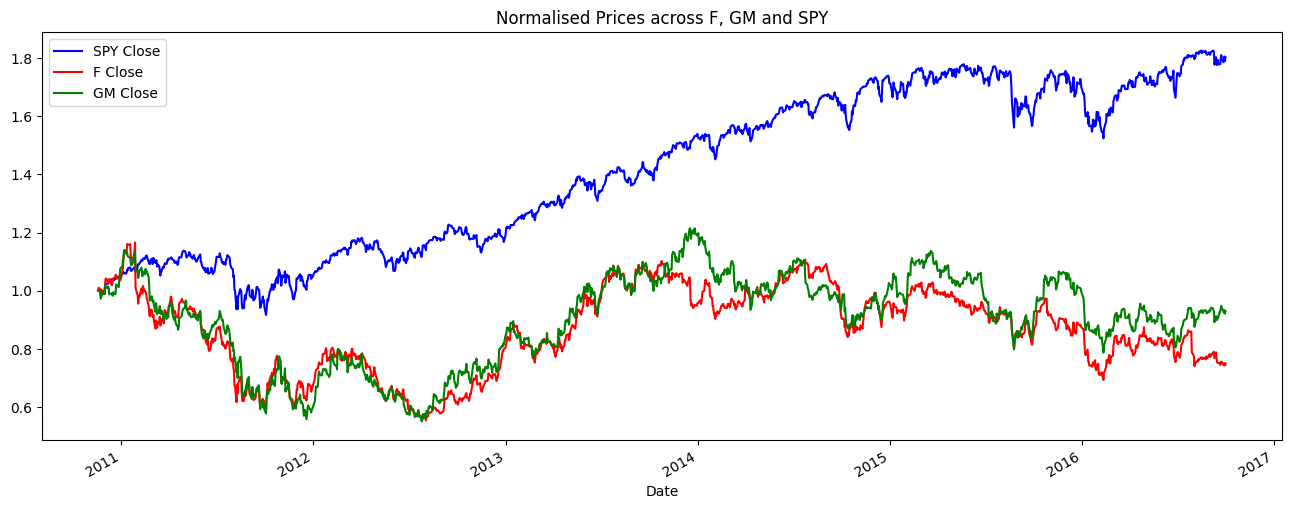

In [59]:
pair_trading.normalized_plot()


In [60]:
returns = pair_trading.returns()
returns

,SPY Close,GM Close,F Close
Date,,,
2010-11-19 00:00:00+00:00,0.0027,0.0020,0.0099
2010-11-22 00:00:00+00:00,-0.0008,-0.0053,-0.0049
2010-11-23 00:00:00+00:00,-0.0146,-0.0247,-0.0314
2010-11-24 00:00:00+00:00,0.0147,0.0069,0.0158
2010-11-26 00:00:00+00:00,-0.0117,0.0095,0.0094
...,...,...,...
2016-09-26 00:00:00+00:00,-0.0081,-0.0100,-0.0132
2016-09-27 00:00:00+00:00,0.0062,-0.0063,-0.0025
2016-09-28 00:00:00+00:00,0.0050,0.0094,0.0091


In [61]:
prices = pair_trading.get_close_prices()
prices

,F Close,SPY Close,GM Close
Date,,,
2010-11-18 00:00:00+00:00,16.12,119.96,34.19
2010-11-19 00:00:00+00:00,16.28,120.29,34.26
2010-11-22 00:00:00+00:00,16.20,120.19,34.08
2010-11-23 00:00:00+00:00,15.70,118.45,33.25
2010-11-24 00:00:00+00:00,15.95,120.20,33.48
...,...,...,...
2016-09-26 00:00:00+00:00,12.01,214.24,31.80
2016-09-27 00:00:00+00:00,11.98,215.57,31.60
2016-09-28 00:00:00+00:00,12.09,216.64,31.90


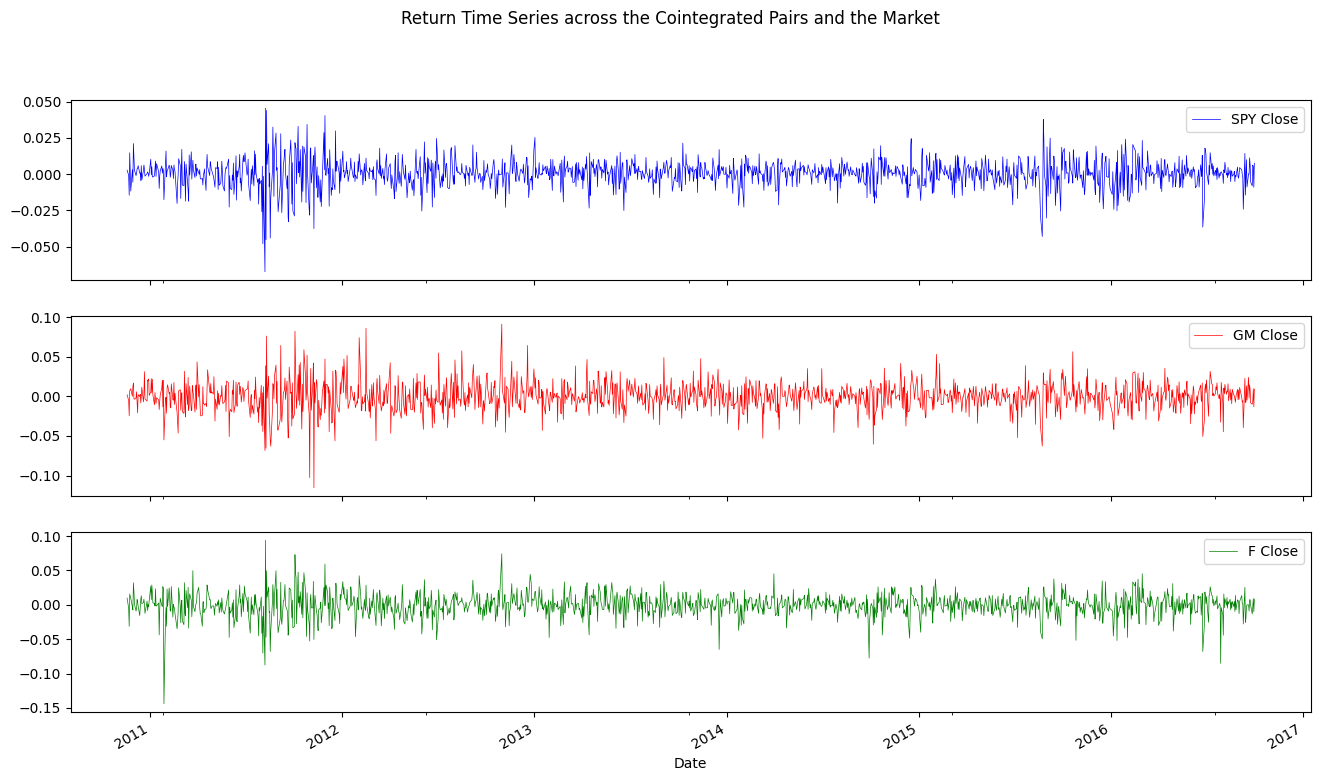

In [62]:
pair_trading.returns_plot()


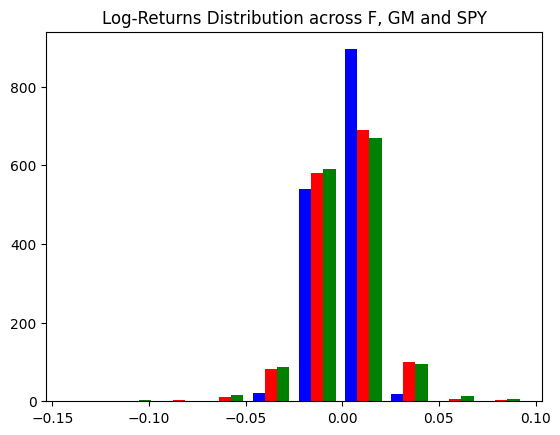

In [63]:
pair_trading.returns_dist()


#### Scatter Plot Analysis

You can see from the scatter plot the two stock prices are quite closely related in a linear fashion, although you can visualize some noise around the data, which is driven mainly by the Brownian Motion component in the prices.

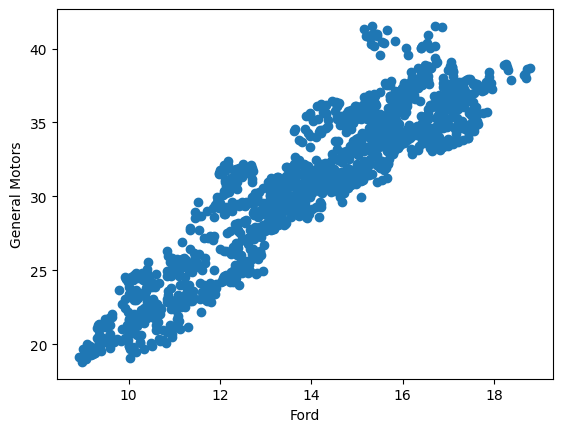

In [64]:
F_close = prices['F Close']
GM_close = prices['GM Close']
pair_trading.scatter_plot(F_close,GM_close)

## Johansen Cointegrated test

The Johansen test named after Søren Johansen, is a procedure for testing cointegration of several, say k, I(1) time series. We will use this test as it could permit more than one cointegrating relationship so is more generally applicable than the Engle-Granger test which is based on the Dickey–Fuller (or the augmented) test for unit roots in the residuals from a single (estimated) cointegrating relationship. We will also use the Engle-Grager in this context, given that we are investigating two stocks only.

There are two types of Johansen test, either with trace or with eigenvalue, and the inferences might be a little bit different. The null hypothesis for the trace test is that the number of cointegration vectors is $r = r* < k$, vs the alternative that $r = k$. Testing proceeds sequentially for $r* = 1,2$ etc. and the first non-rejection of the null is taken as an estimate of r. The null hypothesis for the "maximum eigenvalue" test is as for the trace test but the alternative is $r = r* + 1$ and, again, testing proceeds sequentially for $r* = 1,2$,etc., with the first non-rejection used as an estimator for $r$.

Just like a unit root test, there can be a constant term, a trend term, both, or neither in the model. We will see below the Vector Autoregressive model:

${\displaystyle X_{t}=\mu +\Phi D_{t}+\Pi _{p}X_{t-p}+\cdots +\Pi _{1}X_{t-1}+e_{t},\quad t=1,\dots ,T}$

There is a possibility of specifying an error correction, which is the VECM, for instance the longrun VECM is:

${\displaystyle \Delta X_{t}=\mu +\Phi D_{t}+\Pi X_{t-p}+\Gamma _{p-1}\Delta X_{t-p+1}+\cdots +\Gamma _{1}\Delta X_{t-1}+\varepsilon _{t},\quad t=1,\dots ,T}$

In the meantime, we will show you the test of the Johansen test.



In [65]:
pair_trading.cointegrated_test()

Trace statistic r=0, r=1, etc:
[26.80731  6.73582  1.14126]

Critical Values at 90%, 95%, 99%
[[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

 Eigenvectors (coint weights?)
[[  2.59582   1.75981   3.63346]
 [ 18.43525  -5.27481  -1.85527]
 [-19.59135  -2.77562   1.25439]]


We notice that eigenvectors are not normalised, and for this pair to be traded we therefore need to normalise the eigenvectors.

### Vector Auto Regression

The Vector Autoregression (VAR) is a stochastic process model used to capture the relationship between multiple quantities as they change over time, and generalize the single-variable (univariate) autoregressive model by allowing for multivariate time series. Like the autoregressive model, each variable has an equation modelling its evolution over time. This equation includes the variable's lagged (past) values, the lagged values of the other variables in the model, and an error term.

${\displaystyle X_{t}=\mu +\Phi D_{t}+\Pi _{p}X_{t-p}+\cdots +\Pi _{1}X_{t-1}+e_{t},\quad t=1,\dots ,T}$


A VAR is a stochastic matrix difference equation, where shocks are uncorrelated.

#### Conditions for Auto-Regressive Models


- ${\displaystyle \mathbb {E} (e_{t})=0\,}$ (so every error term has a mean of zero)

- ${\displaystyle \mathbb {E} (e_{t}e_{t}')=\Omega \,}$ (i.e. the contemporaneous covariance matrix of error terms is a $k×k$ positive-semidefinite matrix denoted Ω.)

- ${\displaystyle \mathrm {E} (e_{t}e_{t-k}')=0\,} \forall k ≠ 0$ (i.e. there is no serial correlation in individual error terms)

In [66]:
results = pair_trading.vector_autoregression(2)

results.summary()

C:\Users\domen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Jan, 2025
Time:                     18:49:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -26.8046
Nobs:                     1474.00    HQIC:                  -26.8519
Log likelihood:           13557.0    FPE:                2.11907e-12
AIC:                     -26.8800    Det(Omega_mle):     2.08916e-12
--------------------------------------------------------------------
Results for equation SPY Close
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000410         0.000251            1.632           0.103
L1.SPY Close        -0.055969         0.038171           -1.466           0.143
L1.F Close           0.004361         0.023193            0.

### Residual Autocorrelations

As you can see, the residual autocorrelations are very close to zero, which is expected.

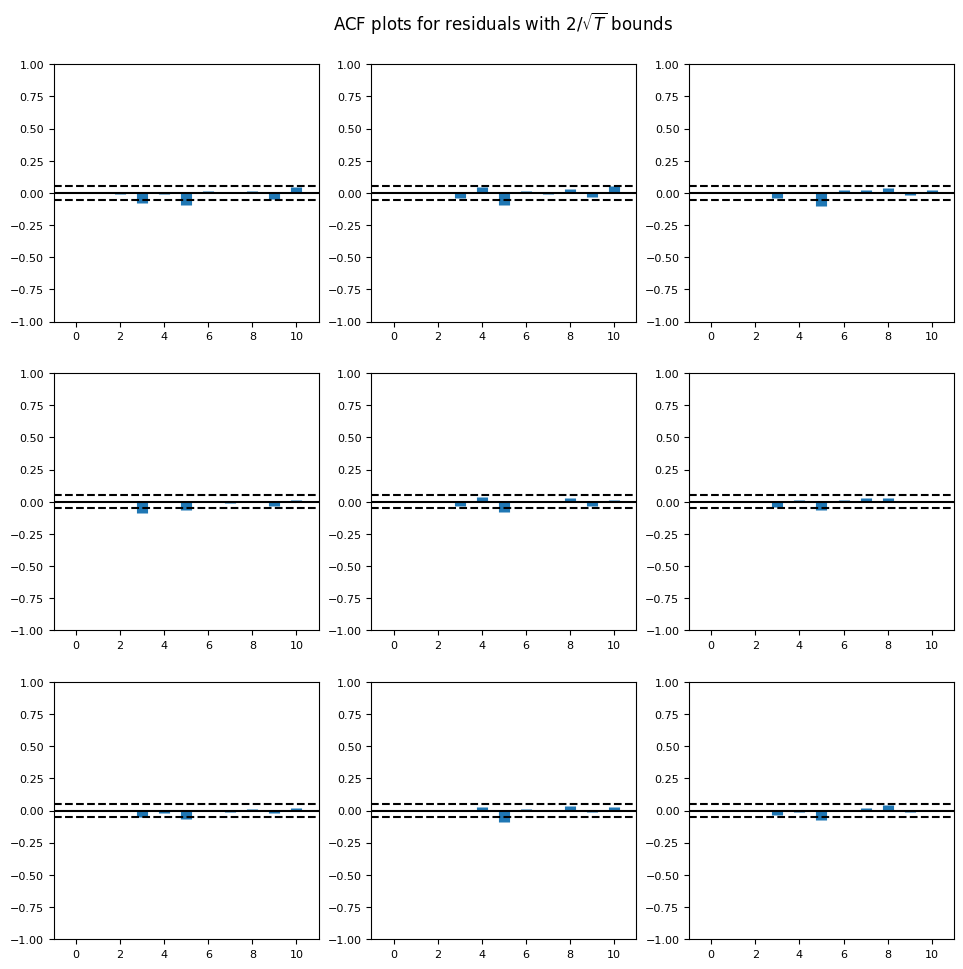

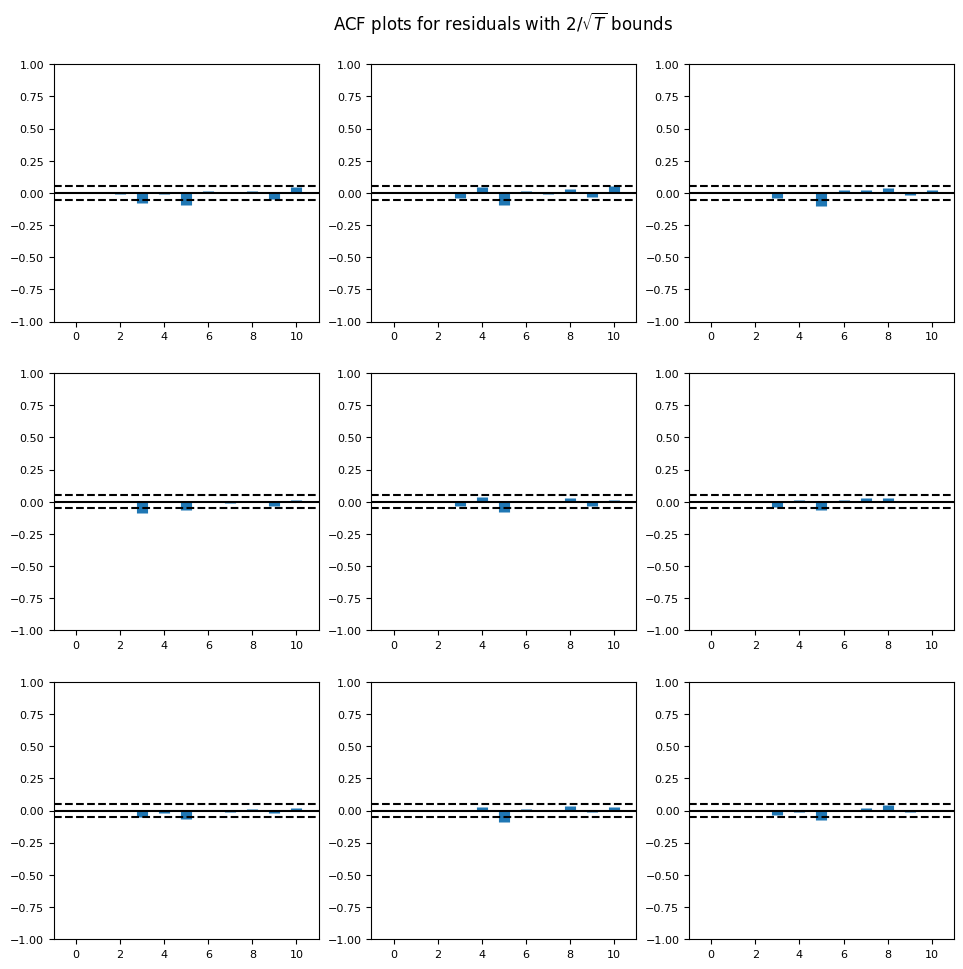

In [67]:
results.plot_acorr(nlags=10, resid=True, linewidth=8)

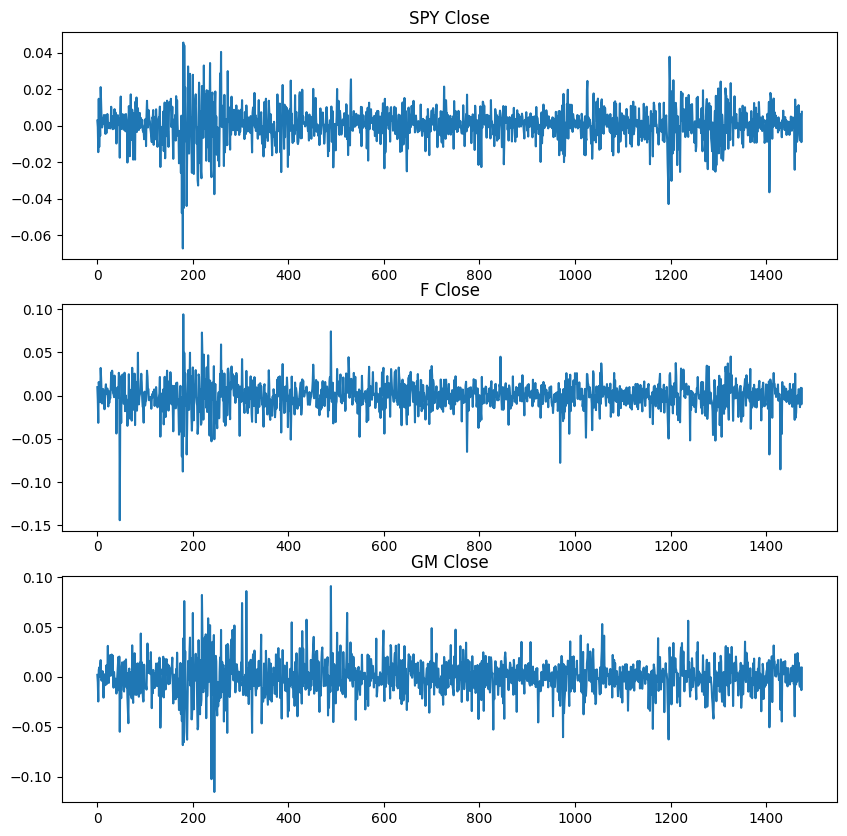

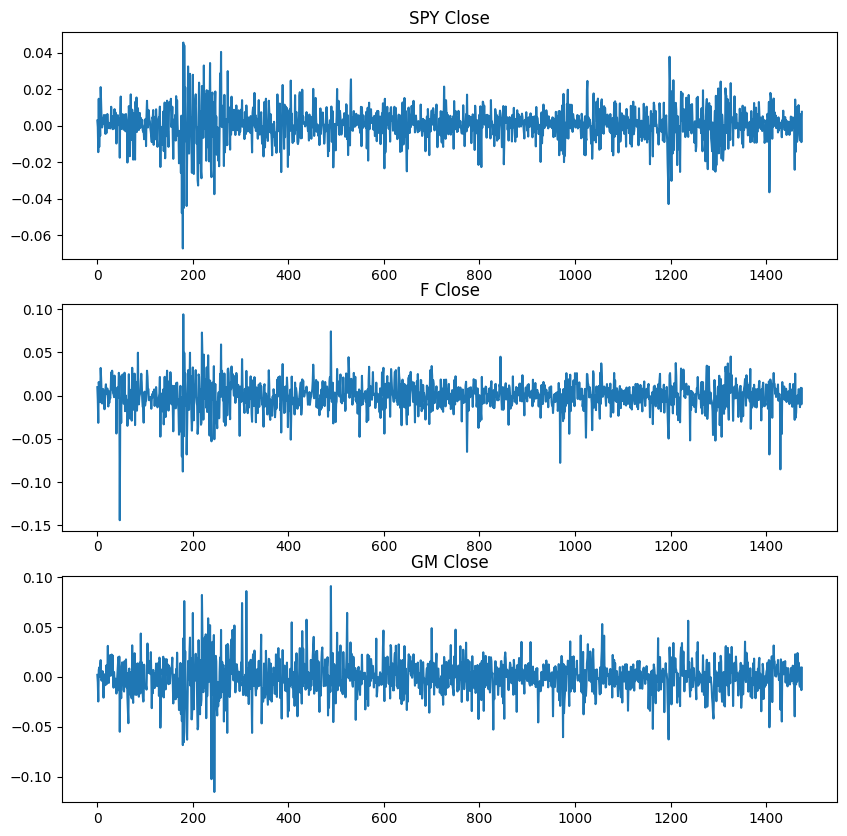

In [68]:
results.plot()

## Cointegration Analysis

Vector Autoregression is not particularly suitable in predicting returns over time, and so the idea is to find a linear combination of two non-stationary time series (i.e. a Brownian Motion) results in the residual, which results stationary. We say that Prices are I(1) time series (non-staionary), whereas their combination -- a residual from naive regression is I(0) time series, or stationary. We do observe relationship in prices, indeed the spread in prices is not a random walk. This type of relationship is defined as cointegration.

First, by definition cointegration is a statistical property of a collection $(X_1, X_2, ..., X_k)$ of time series variables. First, all of the series must be integrated of order $d$. Next, if a linear combination of this collection is integrated of order less than $d$, then the collection is said to be co-integrated. Formally, if $(X,Y,Z)$ are each integrated of order $d$, and so $∃ a,b,c:  aX + bY + cZ$  is integrated of order less than $d$, then $X$, $Y$, and $Z$ are cointegrated.




The objective is to find the stationarity of the spread $e_t$. If this is so, then there is a stochastic process (e.g. random walk) that is so similar in two series that it gets removed by linear differencing.

$P^A_t = P^A_0 + \Sigma e^A_s$

This is the integrated process (and we call it integrated because in continous time this summation is actually an integral of a Brownian motion)

We will then regress the price of stock A on stock B in a naive fashion and after correcting in an Engle-Grager fashion.

$P^B_t = \beta P^A_{t-1} + e^B_t$

### Naive Linear Regression

We can first perform a naive linear regression in a standard OLS fashion, to get an initial residual in the following manner:

$P^t_A=βP^t_B+μ_e+ε_t$



In [69]:
F_close = prices['F Close']
GM_close = prices['GM Close']
regression_results = pair_trading.linear_regression(F_close, GM_close, add_constant='c')
# Print the regression summary
print(regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:                F Close   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     7998.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:49:21   Log-Likelihood:                -1937.8
No. Observations:                1477   AIC:                             3880.
Df Residuals:                    1475   BIC:                             3890.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6012      0.140     11.416      0.0

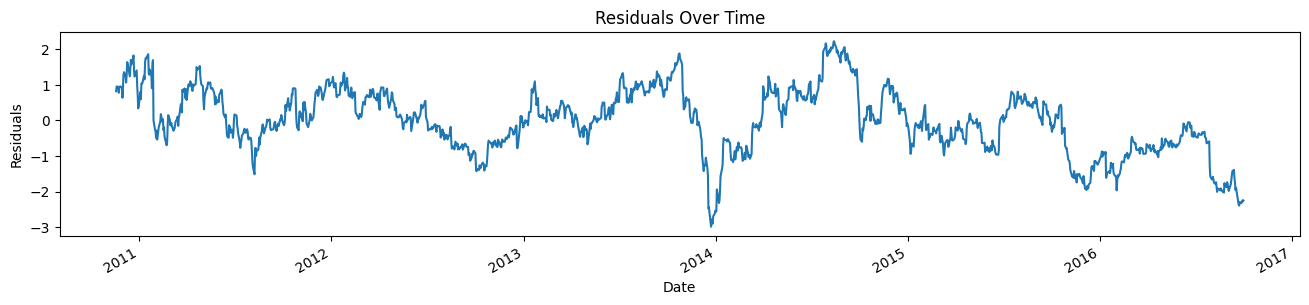

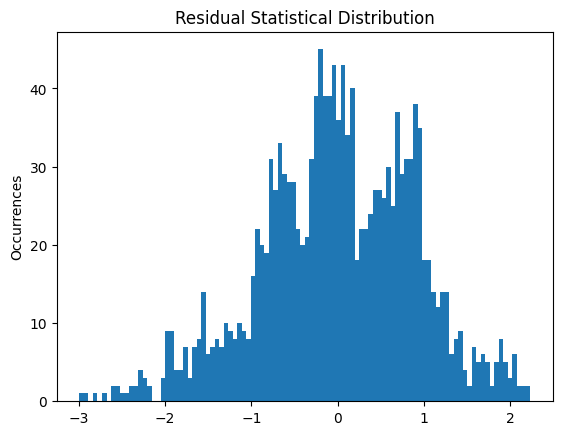

In [70]:
residuals = regression_results.resid
pair_trading.plot_residuals(residuals)

## Engle Granger Correction Equations

From the naive regression, we do want to perform an Equilibrium Correction Model, or error correction equation of the form:

$ΔP^A_t = 𝜑ΔP^B_t −(1− 𝛼)𝑒_𝑡 + 𝑃𝐴 +𝜀_t$

In [71]:
F_close = prices['F Close']
GM_close = prices['GM Close']
engle_granger =  pair_trading.engle_granger_correction(F_close, GM_close, residuals)
print(engle_granger.summary())

                            OLS Regression Results                            
Dep. Variable:                F Close   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     670.4
Date:                Thu, 09 Jan 2025   Prob (F-statistic):          9.56e-208
Time:                        18:49:21   Log-Likelihood:                 536.96
No. Observations:                1476   AIC:                            -1068.
Df Residuals:                    1473   BIC:                            -1052.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.004     -0.508      0.6

### Residuals to Infer Price Movements

Now, residuals are a Gaussian noise centered with mean zero. We can use the residual time series to infer the price movements across normalised time series, given the oscillatory behaviour of the residual time series. Below a sequence of visualizations, residual time series over time compared to normalised prices, the statistical distribution of the residuals.

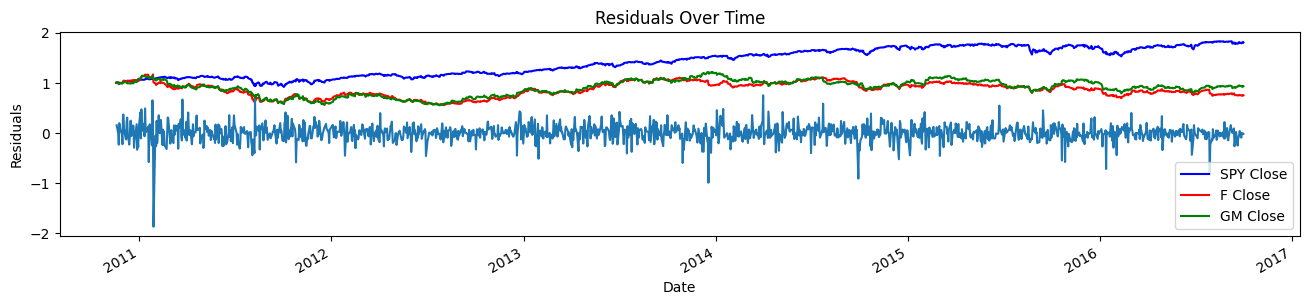

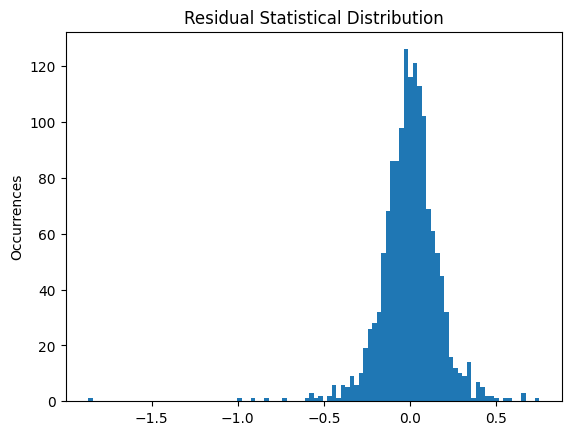

In [72]:
new_residuals = engle_granger.resid
pair_trading.normalized_plot()
pair_trading.plot_residuals(new_residuals)


#

In [73]:
new_residuals.describe()

count    1.4760e+03
mean     3.0087e-18
std      1.6823e-01
min     -1.8676e+00
25%     -8.7311e-02
50%      3.6201e-03
75%      8.7098e-02
max      7.4948e-01
dtype: float64

<Axes: title={'center': 'Normalised Prices across F, GM and SPY'}, xlabel='Date'>

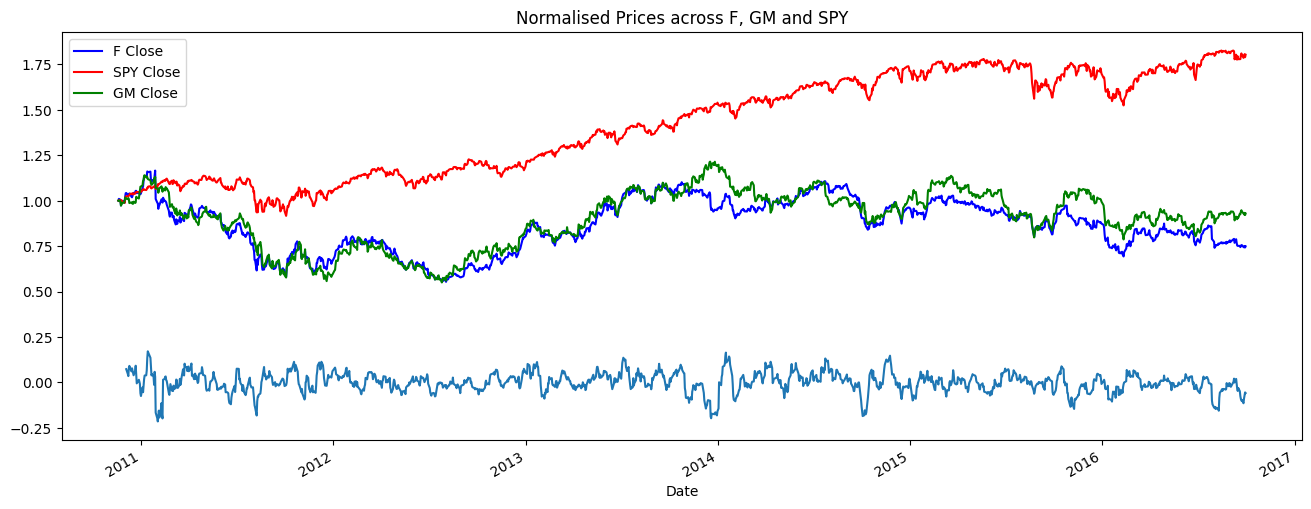

In [74]:
# Apply a moving average with a chosen window size 
window_size = 10
moving_avg = new_residuals.rolling(window=window_size).mean()
pair_trading.normalized_plot()
moving_avg.plot()

In [75]:
moving_avg.describe()

count    1.4670e+03
mean    -2.4968e-05
std      5.4719e-02
min     -2.1487e-01
25%     -2.7989e-02
50%      1.1902e-03
75%      3.4021e-02
max      1.7106e-01
dtype: float64

# Conclusions

After all the statistical analysis, we can further visualize the Moving Average of the residuals in light blue and the normalised prices. An approach to trading this pair would be to analyse this Fourier series and compare with the Normalised prices, and trade a specific portfolio composed by weights generated by the Engle-Granger correction. A fitting to an Ornstein-Uhlenbeck is also possible and would explain the mean-reverting behaviour of the two stock prices and the speed of reversion. Recall that a Ornstein–Uhlenbeck process has the following Stochastic Differential Equation:


${\displaystyle dx_{t}=-\theta \,x_{t}\,dt+\sigma \,dW_{t}}$


${\displaystyle dx_{t}=\theta (\mu -x_{t})\,dt+\sigma \,dW_{t}}$

Therefore, calibration is needed to obtain the speed of reversion, and to compute more precisely these upper and lower bounds where to trade in a statistical arbitrage fashion. These are just possible ideas to then further develop a pair trading strategy, which is not the objective of the notebook, rather the statistical analysis behind the scenes, and stressing the concept of stationarity.